# Лабораторная работа №3 Основные виды нейросетей (CNN и RNN)
## Сергеев Никита
### Вариант 16

In [1]:
import util

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F

S:\study\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Установим начальное значение генеротора случайных чисел

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


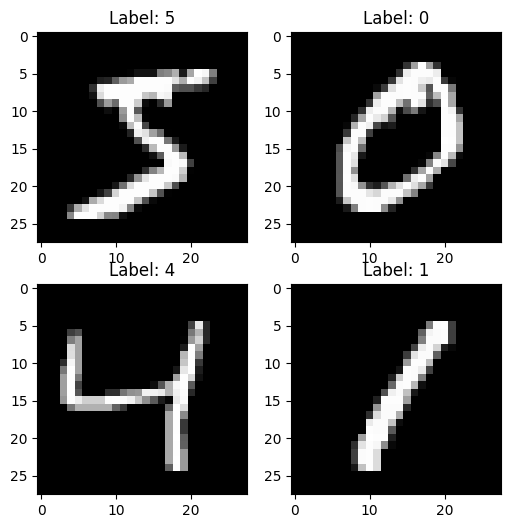

In [3]:
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title(f"Label: {y_train[i]}")
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray');

In [4]:
from util import iterate_minibatches

def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))
        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=32, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        #print(f"Размер входных данных модели: {data.size()}")
        
        output = model(data)
        
        #print(f"Размер выходных данных модели: {data.size()}")
        
        loss = F.nll_loss(output, target)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    batchsize = 32

    for epoch in range(n_epochs):
        print(f"Epoch {epoch} of {n_epochs}")
        train_loss, train_acc = train_epoch(model, opt, batchsize=batchsize)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')
        print(f"Epoch {epoch} error = {1 - val_acc_log[-1][1]:.2%}")
            
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))

**Задание 1:** 
Реализуйте сверточную сеть, которая состоит из двух последовательных применений свертки, relu и max-пулинга, а потом полносвязного слоя. 

Подберите параметры так, чтобы на выходе последнего слоя размерность тензора была 4 x 4 x 16. 
В коде ниже используется обертка nn.Sequential, ознакомьтесь с ее интерфейсом.

Добейтесь, чтобы ошибка классификации после обучения (см. ниже) была не выше 1.5%.

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Изменённый слой пулинга для достижения размера 4x4
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Добавлен padding для корректного уменьшения до 4x4
        )
        
        self.classifier = nn.Linear(4 * 4 * 16, 10)
        
    def forward(self, x):
        #print("Вход:", x.shape)
        x = x.view(-1, 1, 28, 28)
        #print("После view:", x.shape)
        x = self.features(x)
        #print("После features:", x.shape)
        x = x.view(-1, 4 * 4 * 16)
        #print("После второго view:", x.shape)
        out = self.classifier(x)
        #print("Выход:", out.shape)
        return F.log_softmax(out, dim=-1)
    
    
    
        # Изменение формы входного тензора с [32, 784] на [32, 1, 28, 28],
        # что соответствует [размер партии, количество каналов, высота, ширина].
        x = x.view(-1, 1, 28, 28)  # Предполагая, что размер входного изображения - 28x28 и 1 канал (ч/б изображения).

        x = self.features(x)
        x = x.view(-1, 4 * 4 * 16)  # Преобразование в вектор перед подачей в полносвязный слой
        out = self.classifier(x)
        
        
        print("forward out - ", out.shape)
        
        
        
        return F.log_softmax(out, dim=-1)

Посчитаем количество обучаемых параметров сети.

In [6]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

model = ConvNet()
print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 3818


In [63]:
%%time

opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train(model, opt, 7)

TypeError: train() missing 1 required positional argument: 'optimizer'

## Рекуррентные сети
Для рекуррентных сетей используем датасет с именами и будем определять из какого языка произошло данное имя. Для этого построим рекуррентную сеть, которая с именами на уровне символов. Для начала скачаем файлы и конвертируем их к удобному формату (можно не особо вникать в этот код).

In [23]:
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('../data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

['../data/names\\Arabic.txt', '../data/names\\Chinese.txt', '../data/names\\Czech.txt', '../data/names\\Dutch.txt', '../data/names\\English.txt', '../data/names\\French.txt', '../data/names\\German.txt', '../data/names\\Greek.txt', '../data/names\\Irish.txt', '../data/names\\Italian.txt', '../data/names\\Japanese.txt', '../data/names\\Korean.txt', '../data/names\\Polish.txt', '../data/names\\Portuguese.txt', '../data/names\\Russian.txt', '../data/names\\Scottish.txt', '../data/names\\Spanish.txt', '../data/names\\Vietnamese.txt']
Slusarski


Определим несколько удобных функций для конвертации букв и слов в тензоры.

**Задание 2**: напишите последнюю функцию для конвертации слова в тензор.

In [24]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


**Задание 3**: Реализуйте однослойную рекуррентную сеть.

In [25]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()
        
        self.hidden_size = hidden_size

        self.linear = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, input, hidden):
        # Конкатенация входных данных и скрытого состояния
        combined = torch.cat((input, hidden), dim=1)
        hidden = torch.tanh(self.linear(combined))
        return hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnncell = RNNCell(n_letters, n_hidden)

Предсказание будем осуществлять при помощи линейного класссификатора поверх скрытых состояний сети.

In [29]:
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))

Проверим, что все корректно работает: выходы классификаторы должны быть лог-вероятностями.

In [30]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input, hidden))
print(output)
print(torch.exp(output).sum())

tensor([[-2.8984, -2.9415, -2.8581, -2.8410, -2.9371, -2.9461, -2.9032, -2.9389,
         -2.8556, -2.9192, -2.8104, -2.7873, -2.9253, -2.8963, -2.8578, -3.0057,
         -2.9058, -2.8256]], grad_fn=<LogSoftmaxBackward0>)
tensor(1.0000, grad_fn=<SumBackward0>)


In [31]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input[0], hidden))
print(output)
print(torch.exp(output).sum())

tensor([[-2.8984, -2.9415, -2.8581, -2.8410, -2.9371, -2.9461, -2.9032, -2.9389,
         -2.8556, -2.9192, -2.8104, -2.7873, -2.9253, -2.8963, -2.8578, -3.0057,
         -2.9058, -2.8256]], grad_fn=<LogSoftmaxBackward0>)
tensor(1.0000, grad_fn=<SumBackward0>)


Для простоты в этот раз будем оптимизировать не по мини-батчам, а по отдельным примерам. Ниже несколько полезных функций для этого.

In [32]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = names\Dutch / line = Alst
category = names\Irish / line = Dubhan
category = names\Greek / line = Close
category = names\Dutch / line = Sniders
category = names\Czech / line = Sponer
category = names\Chinese / line = Chao
category = names\Czech / line = Kreutschmer
category = names\Greek / line = Metrofanis
category = names\Arabic / line = Nader
category = names\German / line = Vo


**Задание 4:** 
Реализуйте вычисление ответа в функции train. Если все сделано правильно, то точность на обучающей выборке должна быть не менее 70%.

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:08<00:00, 734.42it/s]


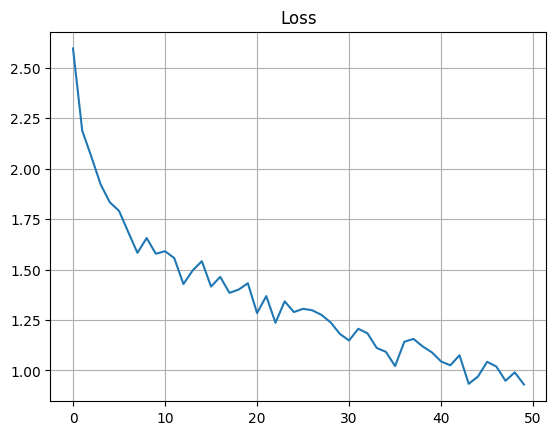

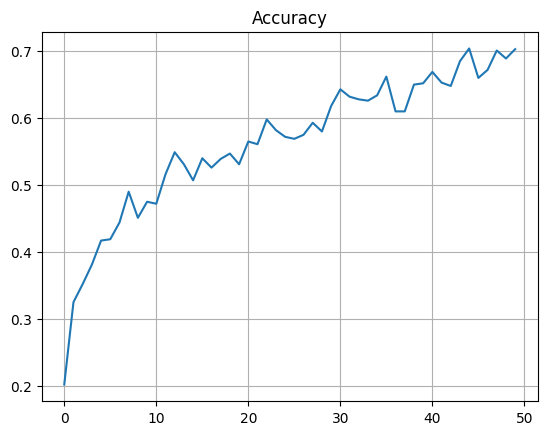

In [36]:
from tqdm.auto import tqdm

def train(category, category_tensor, line_tensor, optimizer):
    hidden = rnncell.initHidden()

    rnncell.zero_grad()
    classifier.zero_grad()

    for i in range(line_tensor.size()[0]):
        hidden = rnncell(line_tensor[i], hidden)

    output = classifier(hidden)
    
    loss = F.nll_loss(output, category_tensor)
    loss.backward()
    optimizer.step()
    
    acc = (categoryFromOutput(output)[0] == category)

    return loss.item(), acc

n_iters = 50000
plot_every = 1000

current_loss = 0
all_losses = []
current_acc = 0
all_accs = []

n_hidden = 128

rnncell = RNNCell(n_letters, n_hidden)
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))
params = list(rnncell.parameters()) + list(classifier.parameters())
opt = torch.optim.RMSprop(params, lr=0.001)
for iter in tqdm(range(1, n_iters + 1)):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    loss, acc = train(category, category_tensor, line_tensor, opt)
    current_loss += loss
    current_acc += acc

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_accs.append(current_acc / plot_every)
        current_acc = 0
        
plt.figure()
plt.title("Loss")
plt.plot(all_losses)
plt.grid()
plt.show()

plt.figure()
plt.title("Accuracy")
plt.plot(all_accs)
plt.grid()
plt.show()

## Затухающие и взрывающиеся градиенты

Эксперименты будем проводить опять на датасете MNIST, но будем работать с полносвязными сетями. В этом разделе мы не будем пытаться подобрать более удачную архитектуру, нам интересно только посмотреть на особенности обучения глубоких сетей.


In [37]:
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

Для экспериментов нам понадобится реализовать сеть, в которой можно легко менять количество слоев. Также эта сеть должна сохранять градиенты на всех слоях, чтобы потом мы могли посмотреть на их величины.

**Задание 5:** допишите недостающую часть кода ниже.

In [45]:
# Глубокая полносвязная сеть
class DeepDenseNet(nn.Module):
    def __init__(self, n_layers, hidden_size, activation):
        super().__init__()
        self.activation = activation
        
        l0 = nn.Linear(X_train.shape[1], hidden_size)
        self.weights = [l0.weight]
        self.layers = [l0]
        
        for _ in range(1, n_layers-1):
            layer = nn.Linear(hidden_size, hidden_size)
            self.layers.append(layer)
            self.layers.append(self.activation())
            self.weights.append(layer.weight)
        
        #self.layers.append(nn.Linear(hidden_size, output_size))
        #self.weights.append(layers[-1].weight)
        
        self.seq = nn.Sequential(*self.layers)
        
        for l in self.weights:
            l.retain_grad()
        
    def forward(self, x):
        out = self.seq(x)
        return F.log_softmax(out, dim=-1)

Модифицируем наши функции обучения, чтобы они также рисовали графики изменения градиентов.

In [46]:
import scipy.sparse.linalg

def train_epoch_grad(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    grads = [[] for l in model.weights]
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
        
        for g, l in zip(grads, model.weights):
            g.append(np.linalg.norm(l.grad.numpy()))
    return loss_log, acc_log, grads


def train_grad(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    grads_log = None

    batchsize = 32

    for epoch in range(n_epochs):
        print(f"Epoch {epoch} of {n_epochs}")
        train_loss, train_acc, grads = train_epoch_grad(model, opt, batchsize=batchsize)
        if grads_log is None:
            grads_log = grads
        else:
            for a, b in zip(grads_log, grads):
                a.extend(b)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        # display all metrics
        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')    

        plt.figure()
        all_vals = []
        for i, g in enumerate(grads_log):
            w = np.ones(100)
            w /= w.sum()
            vals = np.convolve(w, g, mode='valid')
            plt.semilogy(vals, label=str(i+1), color=plt.cm.coolwarm((i / len(grads_log))))
            all_vals.extend(vals)
        plt.legend(loc='best')
        plt.grid()
        plt.show()

**Задание 6:**
* Обучите сети глубины 10 и больше с сигмоидой в качестве активации. Исследуйте, как глубина влияет на качество обучения и поведение градиентов на далеких от выхода слоях.
* Теперь замените активацию на ReLU и посмотрите, что получится.

In [47]:
models = [DeepDenseNet(x*10, 64, nn.Sigmoid) for x in range(1, 5)]

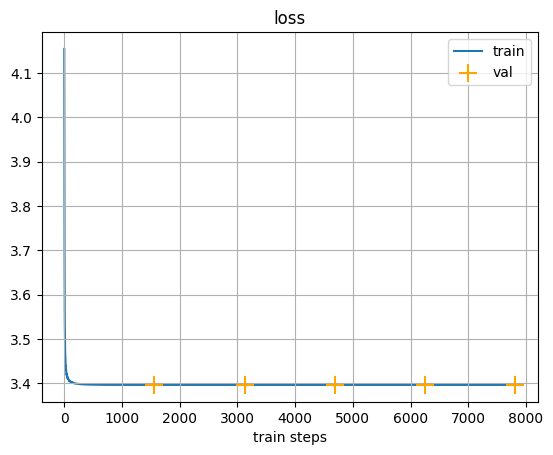

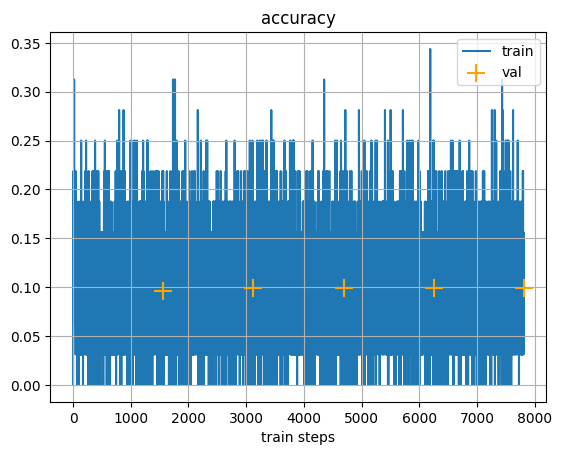

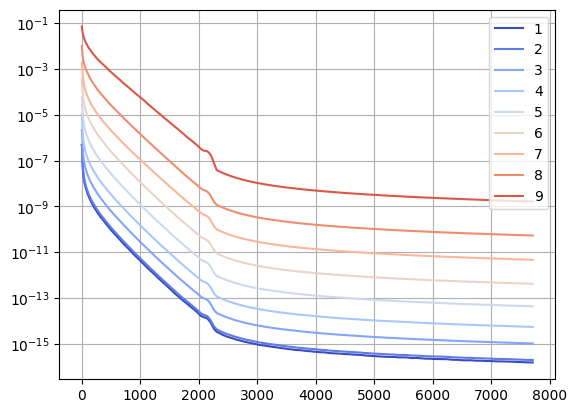

In [50]:
optimizer = torch.optim.RMSprop(models[0].parameters(), lr=0.001)
train_grad(models[0], optimizer, 5)

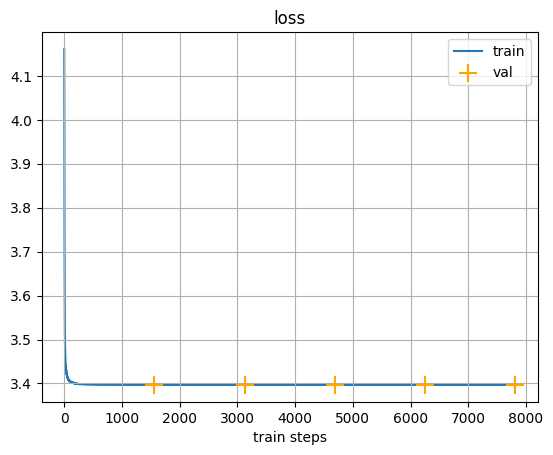

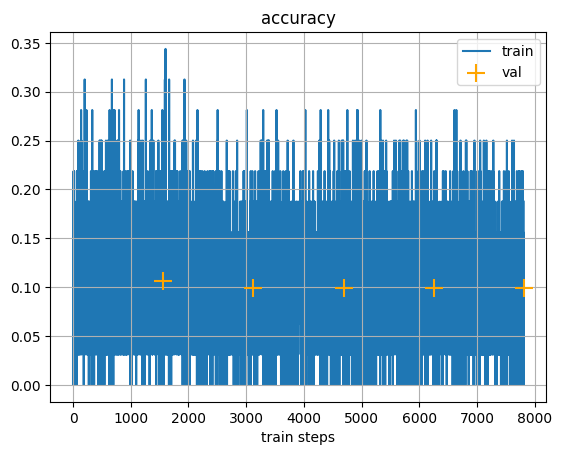

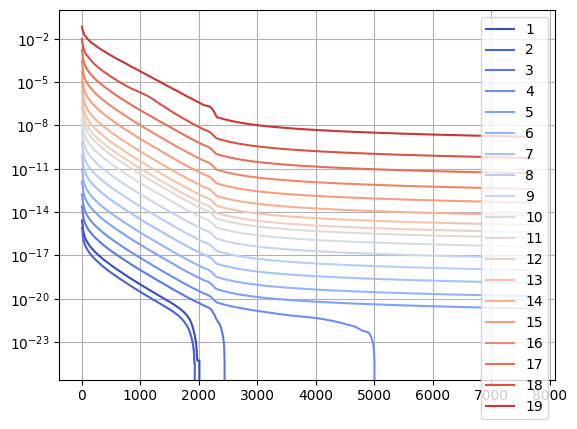

In [51]:
optimizer = torch.optim.RMSprop(models[1].parameters(), lr=0.001)
train_grad(models[1], optimizer, 5)

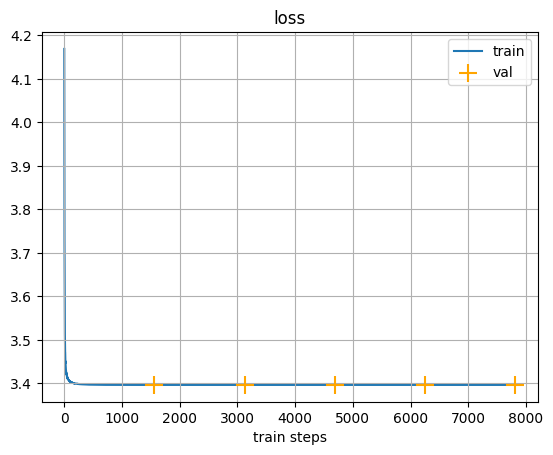

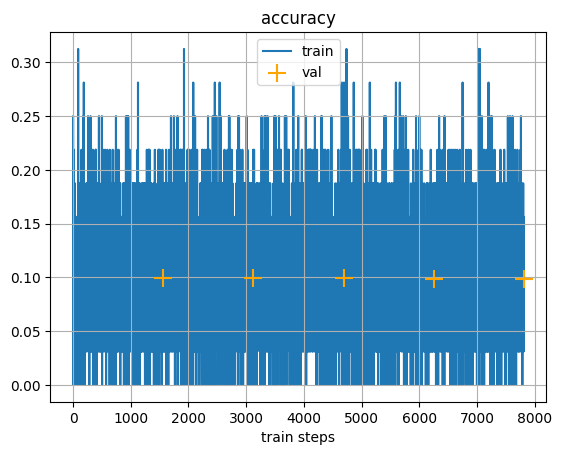

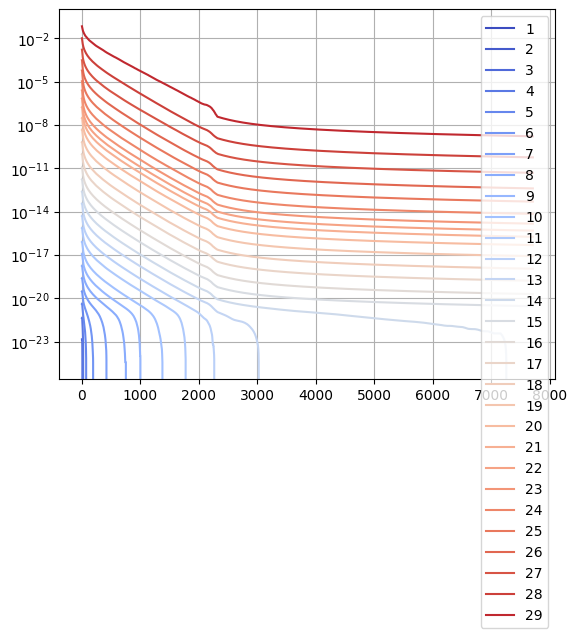

In [53]:
optimizer = torch.optim.RMSprop(models[2].parameters(), lr=0.001)
train_grad(models[2], optimizer, 5)

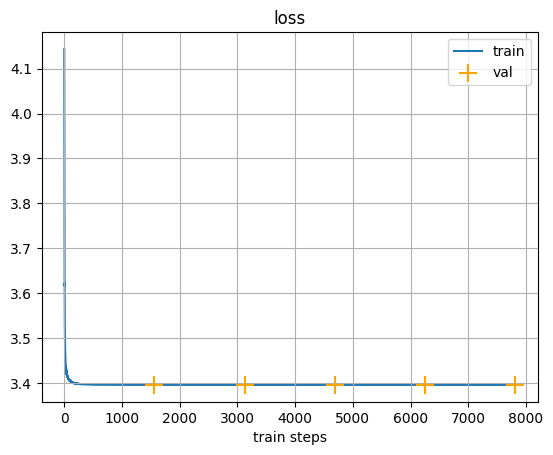

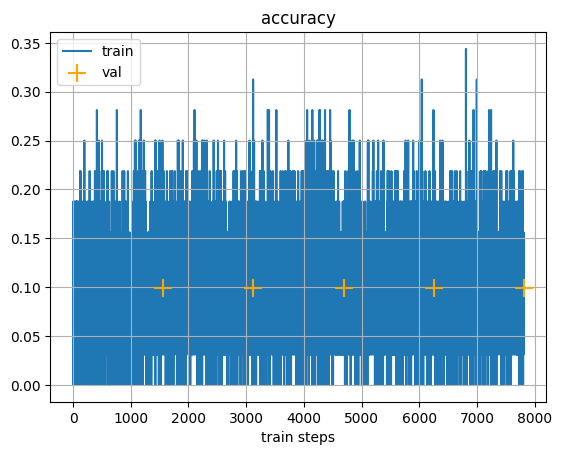

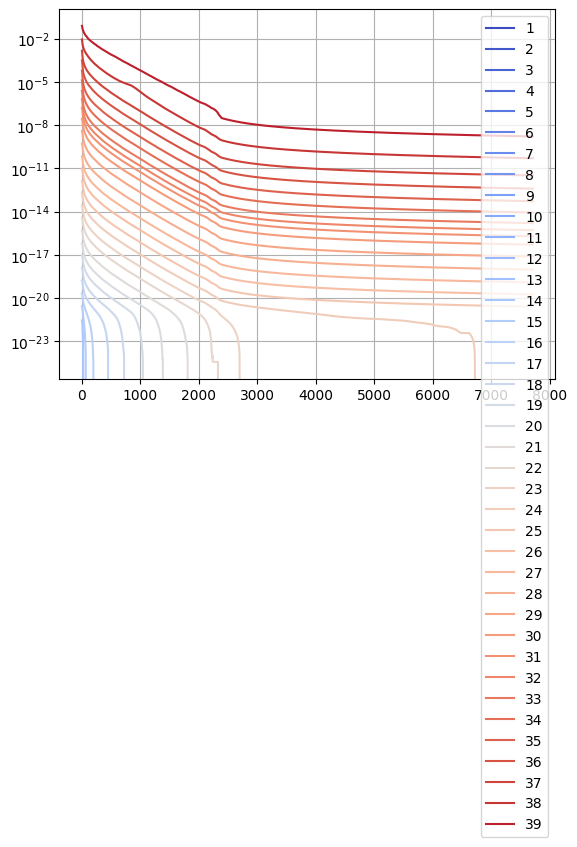

In [54]:
optimizer = torch.optim.RMSprop(models[3].parameters(), lr=0.001)
train_grad(models[3], optimizer, 5)

In [58]:
models_relu = [DeepDenseNet(x*10, 64, nn.ReLU) for x in range(1, 5)]

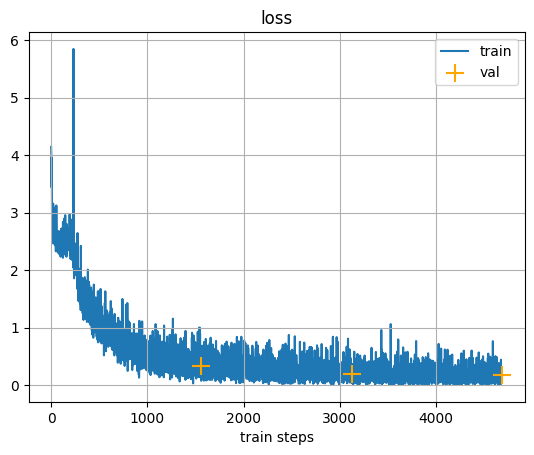

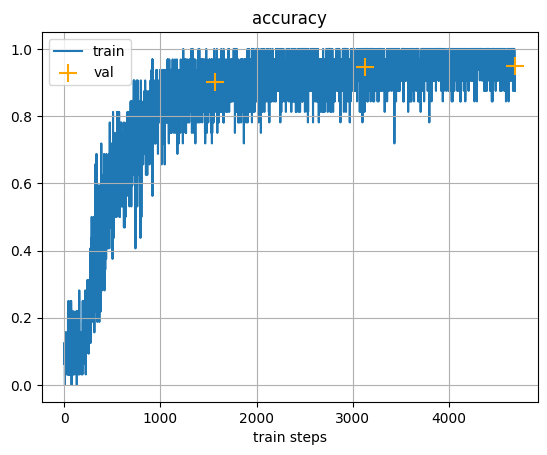

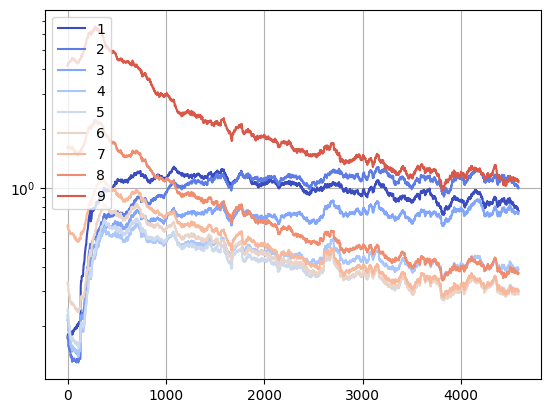

In [59]:
optimizer = torch.optim.RMSprop(models_relu[0].parameters(), lr=0.001)
train_grad(models_relu[0], optimizer, 3)

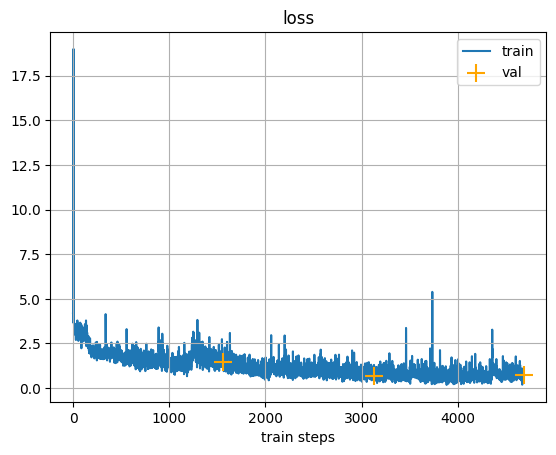

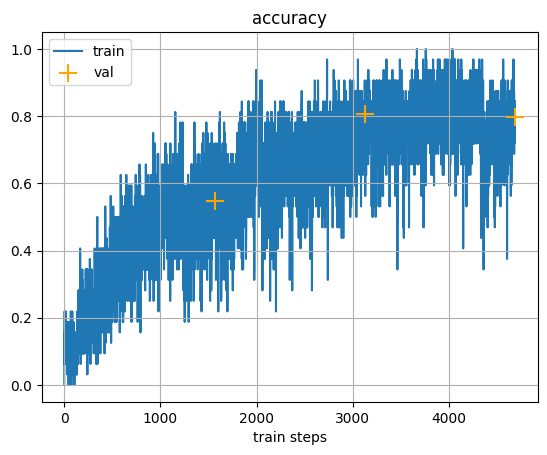

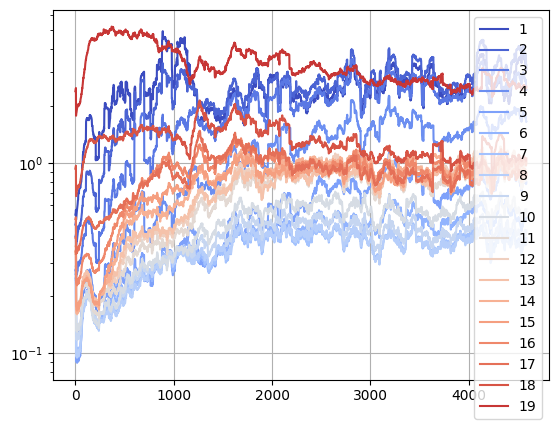

In [60]:
optimizer = torch.optim.RMSprop(models_relu[1].parameters(), lr=0.001)
train_grad(models_relu[1], optimizer, 3)

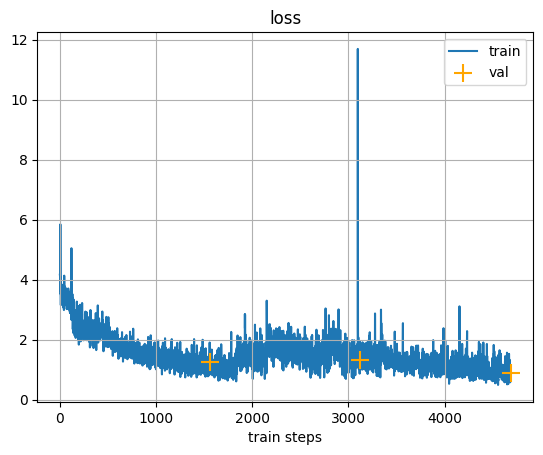

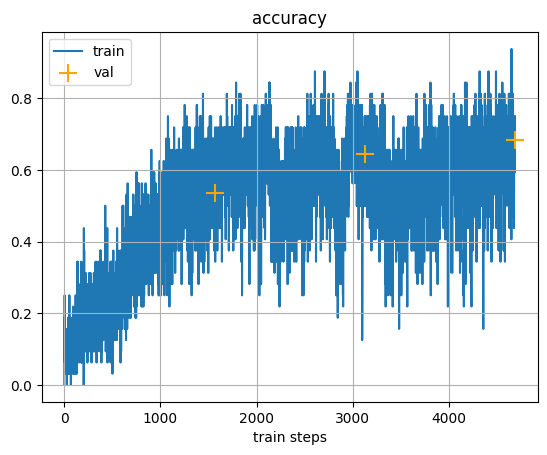

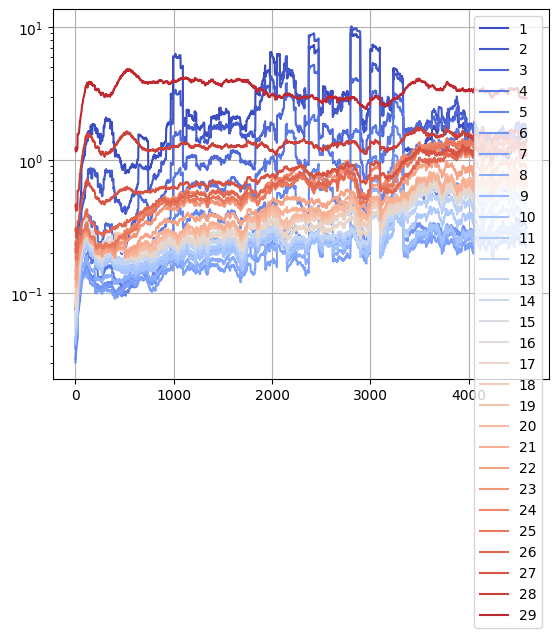

In [61]:
optimizer = torch.optim.RMSprop(models_relu[2].parameters(), lr=0.001)
train_grad(models_relu[2], optimizer, 3)

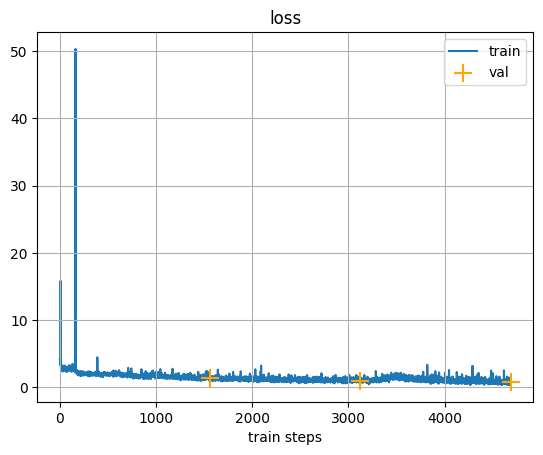

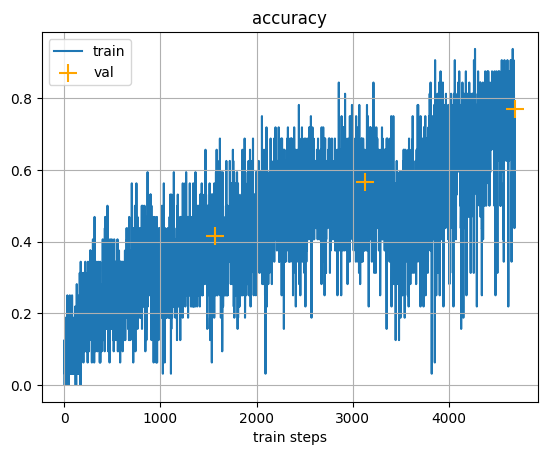

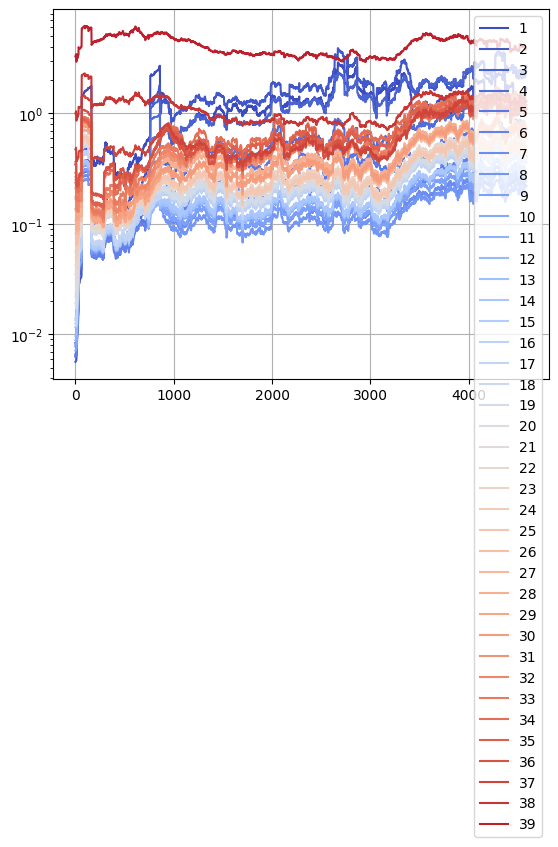

In [62]:
optimizer = torch.optim.RMSprop(models_relu[3].parameters(), lr=0.001)
train_grad(models_relu[3], optimizer, 3)